In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys

sys.path.append('../src')
from model import Señalizador, Resnet18

# Importación de datos
En primera instancia no se modificaron los datos de entrenamiento, ya que se pudo obtener un modelo de precisión aceptable en base a los datos "brutos"

In [8]:
from torchvision.transforms import transforms
import torchvision


train_data = torchvision.datasets.ImageFolder(root='gestos/train',
                                              transform = transforms.ToTensor())

validation_data = torchvision.datasets.ImageFolder(root = 'gestos/valid/',
                                                  transform = transforms.ToTensor())

test_data = torchvision.datasets.ImageFolder(root = 'gestos/test',
                                             transform = transforms.ToTensor())



# Inicialización de modelo 

A continuación se inicializará el mejor modelo que se pudo entrenar. Ya que la mayoría de sus características se definieron de forma empírica: se justificará a continuación las características que se modificaron a lo largo del estudio; las características no justificadas, fueron dejadas como constantes a lo largo de la busqueda del mejor modelo.

 - MaxPooling en todas las capas convolucionales (exceptuando conv3) esto disminuye el tamaño de la imágen a analizar por la capa neuronal.
 - Capas convolucionales con cada vez más filtros, y a la, cada vez menos pixeles gracias al MaxPooling; esto separa todos los filtros posibles hasta tener solo 254 filtros de un solo pixel cada uno, bastante accesible e interpretable para la capa neuronal.
 - Función de activación ReLU para todas las capas.
 - 3 capas completamente conectadas de 128, 16 y 4 neuronas respectivamente
 - Dropout de 20%, ya que en la primera versión de este modelo existía un temprano sobreajuste que impedía el aprendizaje
 - Tasa de aprendizaje 1e-3
 - Optimizador Adam, para así poder concentrarse solo en minimizar el valid loss
 - Perdida de entropía cruzada

In [3]:
model = Señalizador(train_data, validation_data, test_data)
print(model.eval())

Loaders initialized
Señalizador(
  (conv1): Conv2d(3, 18, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(18, 18, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(18, 36, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(36, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(128, 254, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (activation): ReLU()
  (linear1): Linear(in_features=254, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (criterion): CrossEntropyLoss()
)


# Proceso
Como se mencionó anteriormente, se buscó el mejor modelo mayoritariamente de forma empírica, se probaron alrededor de 25 variaciones de el modelo antes expuesto, con un entrenamiento de hasta 100 épocas en promedio, se probó disminuyendo la cantidad de capas convolucionales, disminuyendo o aumentando la cantidad de Neuronas, cambiando la probabilidad de dropout, aumentando el salto (stride) en cada capa, cambiar el MaxPool por un AvgPool, etc. Todas las mutaciones se efectuaron con el objetivo de minimizar la perdida en la validación (valid_loss). 

Todas las mutaciones se efectuaron sin resultados positivos, ninguna variación fue más precisa que el primer modelo.

Inevitablemente, el modelo a presentar es nuestro primer modelo. Para obtener los resultados finales se reinició el aprendizaje 5 veces con el mismo modelo por 25 épocas.

También se entrenó ResNet18 por 20 épocas.

# Resultados
### Modelo propio

A continuación se muestran los gráficos de las inciializaciones aleatorias de nuestro modelo, donde "Señalizador" representa la primera vez que se entrenó el modelo. El error de validación es muy alto ya que se usó reduction = 'sum' en la perdida de entropía cruzada.


<img src="graficos.jpg">

Se obtuvieron todos los reportes de los modelos, y se recopilaron en arrays para ser visualizados fácilmente en gráficos de caja y bigote, para ver la desviación estándar y medias.

A continuación se cargarán los 5 modelos, cada uno con un ciclo de aprendizaje diferente, y el primer reporte corresponde a las métricas del mejor de los 5 modelos según el accuracy, y luego se verán las métricas de los 4 modelos restantes.

In [4]:
model1 = Señalizador(train_data, validation_data, test_data)
model1.load_checkpoint("best_(2)ModeloEduardo_val_loss=-0.0002.pt")
sum_cm = model1.test(True, True)

model2 = Señalizador(train_data, validation_data, test_data)
model2.load_checkpoint("best_(0)ModeloEduardo_val_loss=-3.5137.pt")
sum_cm += model2.test(False, True)

model3 = Señalizador(train_data, validation_data, test_data)
model3.load_checkpoint("best_(1)ModeloEduardo_val_loss=-0.8536.pt")
sum_cm += model3.test(False, True)

model4 = Señalizador(train_data, validation_data, test_data)
model4.load_checkpoint("best_checkpoint_Eduardo.pt")
sum_cm += model4.test(False, True)

model5 = Señalizador(train_data, validation_data, test_data)
model5.load_checkpoint("best_(3)ModeloEduardo_val_loss=-0.0001.pt")
sum_cm += model5.test(False, True)

Loaders initialized


array([[ 6,  5, 12,  7],
       [ 0, 27,  3,  0],
       [ 0,  2, 19,  9],
       [ 0,  1,  2, 27]], dtype=int64)

              precision    recall  f1-score   support

           0       1.00      0.20      0.33        30
           1       0.77      0.90      0.83        30
           2       0.53      0.63      0.58        30
           3       0.63      0.90      0.74        30

    accuracy                           0.66       120
   macro avg       0.73      0.66      0.62       120
weighted avg       0.73      0.66      0.62       120

Loaders initialized
              precision    recall  f1-score   support

           0       1.00      0.17      0.29        30
           1       0.47      0.63      0.54        30
           2       0.22      0.27      0.24        30
           3       0.38      0.50      0.43        30

    accuracy                           0.39       120
   macro avg       0.52      0.39      0.38       120
weighted avg       0.52      0.39      0.38       120

Loaders initialized
              precision    recall  f1-score   support

           0       0.53      0.27  

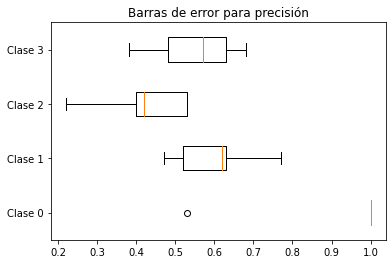

In [5]:
X1 = np.array([1.0, 1.0, 1.0, 0.53, 1.0])
X2 = np.array([0.77, 0.47, 0.52, 0.62, 0.63])
X3 = np.array([0.53, 0.22, 0.4, 0.42, 0.53])
X4 = np.array([0.63, 0.38, 0.48, 0.68, 0.57])
# The most simple boxplot

fig1, ax1 = plt.subplots()
ax1.set_title("Barras de error para precisión")
precision = ax1.boxplot((X1, X2, X3, X4), labels=["Clase 0", "Clase 1", "Clase 2", "Clase 3"], vert = False)

Rápidamente se puede observar que nuestro modelo detecta fácilmente si no hay ningun gesto; tiene problemas para clasificar el gesto 2, y se le hace más fácil clasificar el gesto 1, que el gesto 3.

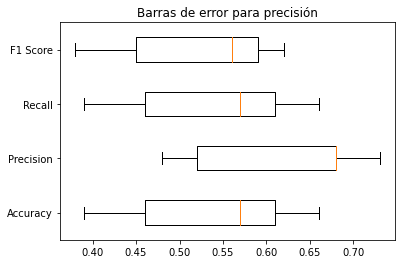

In [6]:
X1 = np.array([0.66, 0.39, 0.46, 0.57, 0.61])
X2 = np.array([0.73, 0.52, 0.48, 0.68, 0.68])
X3 = np.array([0.66, 0.39, 0.46, 0.57, 0.61])
X4 = np.array([0.62, 0.38, 0.45, 0.56, 0.59])
# The most simple boxplot

fig1, ax1 = plt.subplots()
ax1.set_title("Barras de error para precisión")
precision = ax1.boxplot((X1, X2, X3, X4), labels=["Accuracy", "Precision", "Recall", "F1 Score"], vert = False)

### Resultados Resnet18
Resnet está contenido en su jupyter correspondiente en este mismo repositorio

En el caso de Resnet18, los promedios de las métricas fueron:

        precision    recall  f1-score   support
           0       0.47      0.61      0.53        300
           1       0.91      0.55      0.68        300
           2       0.16      0.24      0.19        300
           3       0.41      0.45      0.42        300
    accuracy                           0.49       1200

Lo que más se puede destacar es que al igual que nuestro modelo: Resnet18 tuvo problemas al identificar el gesto 2

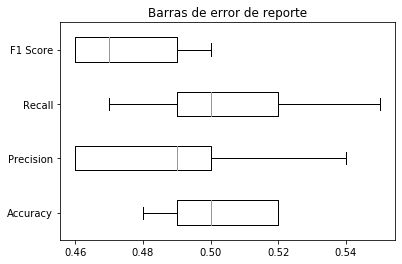

In [4]:
accuracy = np.array([0.52, 0.5, 0.48, 0.49, 0.52])
precision = np.array([0.49, 0.46, 0.46, 0.54, 0.50])
recall = np.array([0.55, 0.5, 0.47, 0.49, 0.52])
f1_score = np.array([0.47 ,0.46, 0.46, 0.5, 0.49])
fig1, ax1 = plt.subplots()
ax1.set_title("Barras de error de reporte")
precision = ax1.boxplot((accuracy, precision, recall, f1_score),
                        labels=["Accuracy", "Precision", "Recall", "F1 Score"], vert = False)

# ¿Que más se pudo haber hecho?
Después de probar tantas mutaciones a las capas convolucionales y neuronales, se empezó a probar con la función de activación SoftPlus para prevenir el estancamiento del gradiente y probar una diferente tasa de aprendizaje. Pero por tema de tiempo límite y capacidad de computo, no se pudo seguir probando.

# Conclusiones

Las redes neuronales convolucionales para clasificación de imágenes, como las entrenadas en este reporte, pueden fácilmente llegar a ser muy complejas, tanto en su estructura como en su afinamiento (hyperparámetros y estructura de la red) y el consumo de recursos requeridos para entrenarlas es muy alto en términos de tiempo y capacidad de procesamiento. Esto supone una brecha importante al querer hacer ingreso al mundo de la investigación de las CNN, u queda demostrado al ver la calidad de las redes entrenadas.